In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


<div id = 1 style="color:white;    
           display:fill;
           border-radius:10px;
           background-color:blue;
           font-size:100%;
           font-family:Verdana;
           letter-spacing:0.5px;
           display:flex;
            justify-content:center;">

<h2 style="padding: 2rem;
          color:white;
          text-align:left;
          margin:0 auto;
          ">
1. 환경 설정(Environment Setting)
</h2>
</div>

## 1.1 Library Import

In [2]:
import warnings
warnings.filterwarnings('ignore')

# utilities 
from termcolor import colored

# 데이터 읽기를 위한 라이브러리
from pathlib import Path
import numpy as np
np.random.seed(0)
import pandas as pd
import math
import gc, os, time
import scipy as sp
import statsmodels.api as sm
from pandas import DataFrame, Series
from datetime import datetime, date, timedelta
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 탐색적 데이터 분석을 위한 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, probplot, boxcox, boxcox_normmax
from scipy.special import boxcox1p
from scipy.stats import skew
from scipy.special import boxcox1p, inv_boxcox

# 모델링을 위한 라이브러리
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression, VarianceThreshold, SelectFromModel, RFE, RFECV
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor

## 1.2 모델 성능을 확인하기 위한 함수

In [3]:
# 모듈 설치
!pip install teddynote -q
from teddynote import utils

# 그래프 사이즈 설정
utils.set_plot_options(figsize=(10, 4))

# MSE 에러 설정
utils.set_plot_error('rmse')

df_results = pd.DataFrame()

## 1.3 DataFrame Option 설정

In [4]:
pd.set_option("display.max_colwidth", 999)  # 컬럼 정보 보여주기
pd.set_option("display.max_rows", 150)  # row 정보 보여주기
# pd.reset_option("display.max_colwidth")
# 참고 : https://pandas.pydata.org/docs/user_guide/options.html

<div id = 2 style="color:white;    
           display:fill;
           border-radius:10px;
           background-color:blue;
           font-size:100%;
           font-family:Verdana;
           letter-spacing:0.5px;
           display:flex;
            justify-content:center;">

<h2 style="padding: 2rem;
          color:white;
          text-align:left;
          margin:0 auto;
          ">
2. 데이타 읽기(Data Loading)
</h2>
</div>

## 2.1 데이타 읽기

In [5]:
data_dir = Path("../input/competitive-data-science-predict-future-sales/")
df_item_category = pd.read_csv(data_dir / "item_categories.csv")  # pd.read_csv(data_dir / "train.csv", index_col="Id")
df_items = pd.read_csv(data_dir / "items.csv")  # pd.read_csv(data_dir / "train.csv", index_col="Id")
df_sales_train = pd.read_csv(data_dir / "sales_train.csv")  # pd.read_csv(data_dir / "train.csv", index_col="Id")
df_shops = pd.read_csv(data_dir / "shops.csv")  # pd.read_csv(data_dir / "train.csv", index_col="Id")
df_test = pd.read_csv(data_dir / "test.csv")  # pd.read_csv(data_dir / "train.csv", index_col="Id")

In [6]:
for df in [df_item_category, df_items, df_sales_train, df_shops, df_test] :
    display(df.head(2))
df_train_raw = pd.merge(df_sales_train, df_items, how='left').drop(['item_name'], axis=1)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",1,76


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320


In [7]:
df_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 7 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date              object 
 1   date_block_num    int64  
 2   shop_id           int64  
 3   item_id           int64  
 4   item_price        float64
 5   item_cnt_day      float64
 6   item_category_id  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 179.2+ MB


In [8]:
print(colored(f"Training data","blue"),"-> ROWS:",df_train_raw.shape[0],"COLUMNS:",df_train_raw.shape[1])
print(colored(f"Test data","red"),"-> ROWS:",df_test.shape[0],"COLUMNS:",df_test.shape[1])

Training data -> ROWS: 2935849 COLUMNS: 7
Test data -> ROWS: 214200 COLUMNS: 3


<div id = 2 style="color:white;    
           display:fill;
           border-radius:10px;
           background-color:blue;
           font-size:100%;
           font-family:Verdana;
           letter-spacing:0.5px;
           display:flex;
            justify-content:center;">

<h2 style="padding: 2rem;
          color:white;
          text-align:left;
          margin:0 auto;
          ">
3. 탐색적 데이타분석 (EDA)
</h2>
</div>

## 3.1 탐색적 데이타분석 준비

### 1) Train Data 기초 분석

In [9]:
# EDA를 위한 학습 데이터를 복사합니다.
df_eda = df_train_raw.copy()

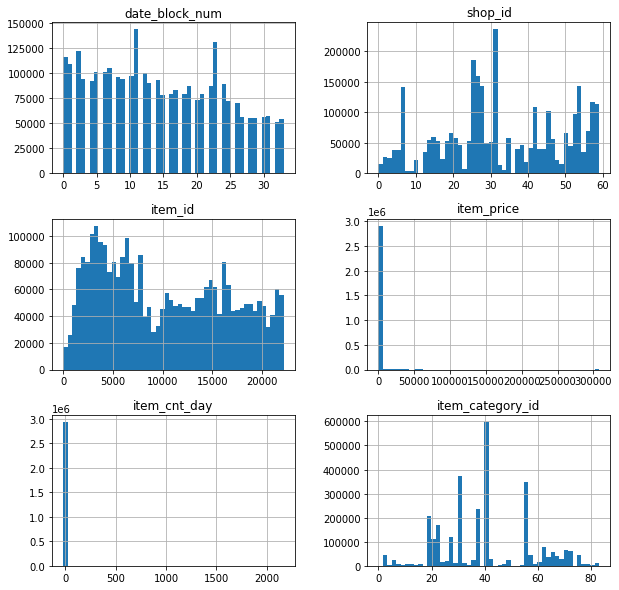

CPU times: user 1.6 s, sys: 165 ms, total: 1.77 s
Wall time: 1.66 s


In [10]:
%%time
%matplotlib inline
df_eda.hist(bins=50, figsize=(10,10))
plt.show()

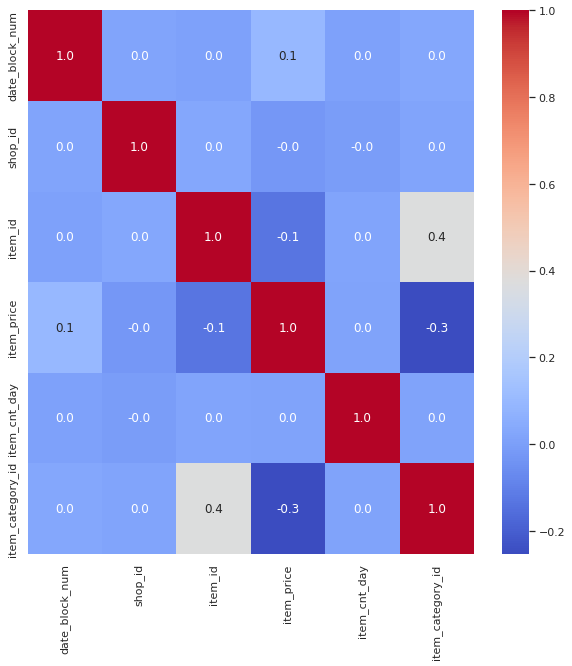

CPU times: user 752 ms, sys: 118 ms, total: 870 ms
Wall time: 738 ms


In [11]:
%%time
sns.set(font_scale=1)
plt.figure(figsize=(10,10))
#sns.heatmap(df_eda.drop('item_price',axis=1).corr(),cmap="BuPu",annot=True)
sns.heatmap(df_eda.corr(),fmt='.1f',cmap="coolwarm",annot=True)
plt.show()